# Initialize libraries and input parameters

In [1]:
import pandas as pd
import random
import re
import numpy as np
import sklearn, sklearn.ensemble

import tpot
import torch
from pronto import Ontology

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import statistics

# reference dataset
input_file = "dataset.tsv"

# name of the column with the reportable name (gating definition)
reportable_name_column = 'Reportable name'

# name of the column with the cell subtype (to be predicted)
cell_subtype_column = 'Cell Subtype'

# name of the column with the marker (to be predicted)
marker_column = 'Marker'

# name of data source (e.g. laboratory or internal)
source_column = 'Laboratory'

# Read data

In [2]:
# read dataset
original_gating_data = pd.read_csv(input_file, sep='\t', encoding='ISO-8859-1')

gating_data = original_gating_data.copy()

total_samples = len(gating_data.index)

print("Number of gating definitions: " + str(total_samples))

unique_samples = len(gating_data[reportable_name_column].unique())

print("Number of unique gating definitions: " + str(unique_samples))

gating_data.drop_duplicates(subset=[reportable_name_column], inplace=True)

# rows that have been annotated with cell type

total_samples = len(gating_data[gating_data[cell_subtype_column].notna()])

print("Number of gating definitions labeled with cell type: " + str(total_samples))

unique_cell_subtypes = len(gating_data[cell_subtype_column].unique())

print("Number of unique cell subtypes: " + str(unique_cell_subtypes))

# rows that have been annotated with cell marker

total_samples = len(gating_data[gating_data[marker_column].notna()])

print("Number of gating definitions labeled with marker type: " + str(total_samples))

unique_markers = len(gating_data[marker_column].unique())

print("Number of unique markers: " + str(unique_markers))

gating_data.head(5)

Number of gating definitions: 4849
Number of unique gating definitions: 3045
Number of gating definitions labeled with cell type: 3043
Number of unique cell subtypes: 56
Number of gating definitions labeled with marker type: 3038
Number of unique markers: 62


,Reportable name,Marker,Laboratory,Cell Subtype
0,CD3+CD4+CD25+ %,CD25,Laboratory 1,"Lymphocyte T, CD4-positive"
1,CD3+CD4+CD25+ ABS,CD25,Laboratory 1,"Lymphocyte T, CD4-positive"
2,CD3+CD4+CD25_APC MESF,CD25,Laboratory 1,"Lymphocyte T, CD4-positive"
3,CD3+CD4+CD25_APC MFI,CD25,Laboratory 1,"Lymphocyte T, CD4-positive"
4,CD3+CD4+CD71+ %,CD71,Laboratory 1,"Lymphocyte T, CD4-positive"


# Functions to create features for machine learning

In [3]:
# tokenize the input based on marker intensity characters, numerical characters and camel case
def tokenize(input_text):
    # marker intensity characters define the end of units
    input_text = re.sub(r'([\+\-\/\\])([^ ])', r'\1 \2', input_text)
    # separation of units written in camel case format
    input_text = re.sub(r'([a-z])([A-Z])', r'\1 \2', input_text)
    # numerical characters define the end of units
    input_text = re.sub(r'/([^a-z^A-Z])([A-Za-z])', r'\1 \2', input_text)
    return input_text

# delete non-alphanumeric characters
def delete_non_alpha(input_text):
    input_text = re.sub(r'[\*\%\/\\\#\_\.\)\(]', r' ', input_text)    
    return input_text

# function that creates the list of features that will be used for machine learning based on gating definitions
def create_list_of_unique_features(input_data):
    reportable_names_all_string = input_data.str.cat(sep='\t')

    # eliminate non-ASCII characters
    # this is done because inputs may have extraneous characters
    reportable_names_all_string = reportable_names_all_string.encode("ascii", "ignore").decode()

    # tokenize the gating definition by adding spaces between units
    reportable_names_all_string = tokenize(reportable_names_all_string)
    
    # delete most non-alphanumeric characters
    # this is done to eliminate intensity markers and other non-alphanumeric characters
    reportable_names_all_string = delete_non_alpha(reportable_names_all_string)    
    reportable_names_all_string = re.sub(r'[\+\-]', r' ', reportable_names_all_string)

    # make all lower case
    reportable_names_all_string = reportable_names_all_string.lower()

    # create a list with the tokens from the gating definition
    reportable_names_unique_substrings = re.split('\t| +', reportable_names_all_string)

    # remove duplicates and delete empty entries
    reportable_names_unique_substrings = list(set(reportable_names_unique_substrings))
    reportable_names_unique_substrings.remove("")
    
    list_of_unique_features = reportable_names_unique_substrings
    
    #print(list_of_unique_features)
    
    print("Number of unique features created:" + str(len(list_of_unique_features)))
    return list_of_unique_features

# function that creates the feature matrix
def create_features(input_data, list_of_unique_features, synonym_map):
    
    feature_matrix = pd.DataFrame(columns=list_of_unique_features)

    for reportable_name in input_data:
        reportable_name = tokenize(reportable_name)
        reportable_name = delete_non_alpha(reportable_name)
                
        # create feature vector starting with all zeros
        feature_list = [0] * len(list_of_unique_features)
        for index,substring in enumerate(list_of_unique_features):
            if substring in synonym_map:
                synonym = synonym_map[substring]
                index = list_of_unique_features.index(synonym)
            # if text unit exists then update feature list
            match_found = False
            # sub-string matches are allowed whenever they are not bounded by numbers (e.g. CD4 will not match CD45)
            if re.search('([^0-9]|^)' + re.escape(substring) + '([^0-9]|$)', reportable_name, re.IGNORECASE):
                match = re.search('([^0-9]|^)' + re.escape(substring) + '([^0-9]|$)', reportable_name, re.IGNORECASE)
                match_found = True
            if match_found == True:
                # once a match occurs then a score is computed based on marker intensity
                next_character = match.group()[-1]
                score = 1
                # check if there is a plus or minus after the text unit
                if next_character == "+":
                    score = 2
                if next_character == "-":
                    score = -1                        
                feature_list[index] = score
        # add feature vector to feature matrix
        feature_matrix = feature_matrix.append(pd.Series(dict(zip(feature_matrix.columns, feature_list))), ignore_index=True)
        
    return feature_matrix

In [4]:
# create the feature matrix based on the input data
gating_data = original_gating_data[original_gating_data[cell_subtype_column].notna()]
gating_data.drop_duplicates(subset=reportable_name_column, keep="first", inplace=True)
input_data = gating_data[reportable_name_column]

list_of_unique_features = create_list_of_unique_features(input_data)
synonym_map = {}
feature_matrix = create_features(input_data, list_of_unique_features, synonym_map)

Number of unique features created:281


# Train and test data

In [5]:
# select target prediction column
y1 = pd.Series(gating_data[cell_subtype_column].astype(str))
X = feature_matrix

# encode the target prediction numerically so that the machine learning algorithm can handle it
le = sklearn.preprocessing.LabelEncoder()
y1.unique()
le.fit(y1.unique())
list(le.classes_)
y_trans = le.transform(y1)
y = pd.Series(index=y1.index, data=y_trans)

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=24)

## Run AutoML algorithm

In [7]:
# # uncomment the lines in this cell to run the autoML algorithm
# clf = tpot.TPOTClassifier(generations=5, population_size=20, cv=5,
#                      random_state=24, verbosity=2, config_dict='TPOT sparse')

# clf.fit(X_train, y_train)

# # save the pipeline in a file
# clf.export('automl_pipeline_cell_subtype.py')

# print("Accuracy on the training set: " + str(clf.score(X_train, y_train)))

# print("Accuracy on the test set: " + str(clf.score(X_test, y_test)))

## Run ML algorithm

In [8]:
# measure performance of the autoML-selected algorithm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# this is the pipeline selected by autoML in the previous step
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LogisticRegression(C=15.0, dual=False, penalty="l2", max_iter=1000)),
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.5, min_samples_leaf=16, min_samples_split=4, n_estimators=100)),
    RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.15000000000000002, min_samples_leaf=4, min_samples_split=4, n_estimators=100)
)

clf = exported_pipeline

In [9]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_train) 

print("Accuracy of machine learning algorithm on the training set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_train, y_pred)) + "%")

y_pred = clf.predict(X_test) 

print("Accuracy of machine learning algorithm on the test set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

y_pred = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10)

print("Accuracy of machine learning algorithm on 10-fold cross-validation: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y, y_pred)) + "%")

Accuracy of machine learning algorithm on the training set: 99.88%
Accuracy of machine learning algorithm on the test set: 97.21%
Accuracy of machine learning algorithm on 10-fold cross-validation: 94.18%


In [10]:
# compute probability values
clf1 = sklearn.multiclass.OneVsRestClassifier(exported_pipeline)

y_score = sklearn.model_selection.cross_val_predict(clf1, X, y, cv=10, method='predict_proba')

In [11]:
# de-encode the labels of the test set and the predicted labels
y_labels = le.inverse_transform(y)

y_pred_labels = le.inverse_transform(y_pred)

# Evaluation

Number of classes: 55
Median AUROC: 0.9985202236106544
Average AUROC: 0.9506582343150565
St. dev. AUROC: 0.12257297956205847


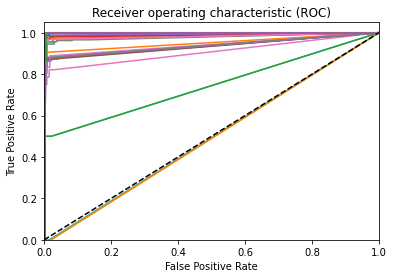

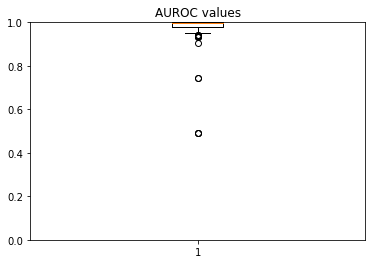

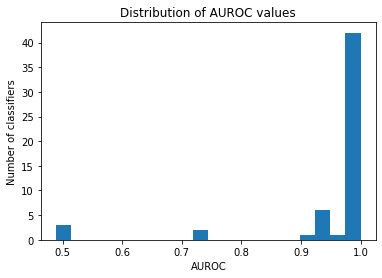

AUROCs:
[1.0, 0.9996710526315788, 0.9980439950648491, 0.9995067412035515, 0.9998355804011838, 1.0, 0.9069296375266525, 0.9988894373149062, 0.9999893984691389, 1.0, 1.0, 1.0, 1.0, 0.9374799814020768, 0.9349189343083193, 0.983304600559184, 0.983846415222562, 0.9842963242698892, 0.9997332006177432, 0.743583415597236, 0.9924228362009471, 0.9523432253808183, 0.999561403508772, 0.9998903508771929, 0.9986842105263158, 0.9346252366633255, 0.9418181818181819, 0.9776606763169557, 0.9913052296103144, 0.9998924791503048, 0.9920628861676897, 0.9846000318106956, 0.7439947351102336, 0.9886384592469301, 0.9382138639937748, 0.9983552631578947, 0.9980263157894738, 0.9396599572293778, 0.9989291598023065, 1.0, 0.9998672419515433, 0.9985202236106544, 0.9999225578050669, 0.999013482407103, 0.9935313131630895, 1.0, 0.9833836696225849, 1.0, 0.4893162393162393, 0.4927679158448389, 0.9995604336779863, 0.4906311637080868, 0.9992025518341308, 1.0, 0.9997728774364056]


In [12]:
# Compute ROC curve and ROC area for each class

n_classes = len(y.unique())

fpr = dict()
tpr = dict()
roc_auc = dict()
y_dummies = pd.get_dummies(y, drop_first=False).values
y_score = np.nan_to_num(y_score)

for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_dummies[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

aurocs = [float(i) for i in roc_auc.values()]

print("Number of classes: " + str(n_classes))
print("Median AUROC: " + str(statistics.median(aurocs)))
print("Average AUROC: " + str(statistics.mean(aurocs)))
print("St. dev. AUROC: " + str(statistics.stdev(aurocs)))

# Plot of a ROC curve for a specific class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

plt.figure()
plt.boxplot(aurocs)
plt.ylim([0.0, 1.0])
plt.title('AUROC values')
plt.show()

plt.figure()
plt.hist(aurocs, bins=20)
plt.ylabel('Number of classifiers')
plt.xlabel('AUROC')
plt.title('Distribution of AUROC values')
plt.show()

print("AUROCs:")
print(aurocs)

In [13]:
# spot-check quality of predictions
y_reportable_name = gating_data.loc[y.index.values, reportable_name_column]

output_results = pd.DataFrame(columns=[reportable_name_column, 'Predicted', 'Actual'])

output_results["Actual"] = y_labels
output_results["Predicted"] = y_pred_labels
output_results[reportable_name_column] = y_reportable_name.values

output_results.tail(15)

,Reportable name,Predicted,Actual
3028,PDL1 [CD3+/CD8+/CD62L-/CD127+],"Lymphocyte T, CD8-positive, effector memory","Lymphocyte T, CD8-positive, effector memory"
3029,PDL1+/CD3+/CD4+/CD45RO-/CCR7-,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, effector memory, t..."
3030,PDL1+/CD3+/CD4+/CD45RO-/CCR7+,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, naive"
3031,PDL1+/CD3+/CD4+/CD45RO+/CCR7-,"Lymphocyte T, CD4-positive, effector memory","Lymphocyte T, CD4-positive, effector memory"
3032,PDL1+/CD3+/CD4+/CD45RO+/CCR7+,"Lymphocyte T, CD4-positive, central memory","Lymphocyte T, CD4-positive, central memory"
3033,PDL1+/CD3+/CD4+/CD45RO+/CD62L-/CCR7-,"Lymphocyte T, CD4-positive, effector memory","Lymphocyte T, CD4-positive, effector memory"
3034,PDL1+/CD3+/CD4+/CD45RO+/CD62L+/CCR7+,"Lymphocyte T, CD4-positive, central memory","Lymphocyte T, CD4-positive, central memory"
3035,PDL1+/CD3+/CD4+/CD62L-/CD127+,"Lymphocyte T, CD4-positive, effector memory","Lymphocyte T, CD4-positive, effector memory"
3036,PDL1+/CD3+/CD8+/CD45RO-/CCR7-,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, effector memory, t..."
3037,PDL1+/CD3+/CD8+/CD45RO-/CCR7+,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, naive"


In [14]:
# spot-check errors

total_samples = len(output_results.index)

print("Total samples: " + str(total_samples))

total_errors = len(output_results[output_results["Predicted"] != output_results["Actual"]])

print("Total correctly classified: " + str(total_samples - total_errors))

print("Total classification errors: " + str(total_errors))

errors = output_results[output_results["Predicted"] != output_results["Actual"]][["Predicted", "Actual"]]

third_segment_error = 0

for index, error in errors.iterrows():
    predicted_label_segments = error["Predicted"].split(", ")
    actual_label_segments = error["Actual"].split(", ")
    if len(predicted_label_segments) >= 2 and len(actual_label_segments) >= 2:
        if predicted_label_segments[0] == actual_label_segments[0]:
            if predicted_label_segments[1] == actual_label_segments[1]:
                third_segment_error += 1
                
print("Errors in third segment discrepancies: " + str(third_segment_error))

first_segment_error = 0

for index, error in errors.iterrows():
    predicted_label_segments = error["Predicted"].split(", ")
    actual_label_segments = error["Actual"].split(", ")
    if predicted_label_segments[0] != actual_label_segments[0]:
        first_segment_error += 1
                
print("Errors in first segment discrepancies: " + str(first_segment_error))

pd.set_option('display.max_rows', 15)

errors.tail(15)


Total samples: 3043
Total correctly classified: 2866
Total classification errors: 177
Errors in third segment discrepancies: 124
Errors in first segment discrepancies: 34


,Predicted,Actual
2985,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, naive"
2992,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, effector memory, t..."
2993,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, naive"
2999,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, effector memory, t..."
3000,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, naive"
3006,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, effector memory, t..."
3007,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, naive"
3014,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, effector memory, t..."
3015,"Lymphocyte T, CD4-positive","Lymphocyte T, CD4-positive, naive"
3022,"Lymphocyte T, CD8-positive","Lymphocyte T, CD8-positive, effector memory, t..."


# Evaluate predictions based on data source (i.e. different laboratories or internal)

In [15]:
# select data with source name
gating_data = gating_data[gating_data[source_column].notna()]

total_samples = len(gating_data.index)

print("Number of gating definitions: " + str(total_samples))

# list sources

gating_data[source_column] = gating_data[source_column].str.lower()

sources = gating_data[source_column].unique()

sources = sorted(sources, key=str.lower)

print("Unique sources: " + str(sources))

total_count_source = int(len(gating_data[source_column]))

for source in sources:
    count_source = sum(gating_data[source_column] == source)
    percentage_count_source = round(100 * (count_source / total_count_source),1)
    print(source + ": " + str(count_source) + " (" + str(percentage_count_source) + "%)")

Number of gating definitions: 3043
Unique sources: ['internal', 'laboratory 1', 'laboratory 2', 'laboratory 3']
internal: 92 (3.0%)
laboratory 1: 2551 (83.8%)
laboratory 2: 184 (6.0%)
laboratory 3: 216 (7.1%)


In [16]:
# algorithm performance for each source alone and with different levels of train / test split

for test_fraction in [0.9, 0.5]:
    train_fraction = 1 - test_fraction
    print("---------------------------")
    print("Fraction used for training: " + str(train_fraction))
    print("---------------------------")
    for source in sources:
        print("Source: " + source)

        single_source_data = (gating_data[source_column] == source).values 
        X_single_source = feature_matrix[single_source_data]
        y_single_source = y[single_source_data]


        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_single_source, y_single_source, test_size=test_fraction, random_state=24)

        print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
        print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")

        clf = exported_pipeline

        clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test) 

        print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

---------------------------
Fraction used for training: 0.09999999999999998
---------------------------
Source: internal
Training set size: 9 (0.30%)
Test set size: 83 (2.73%)
Accuracy of machine learning algorithm on the test set: 25.3%
Source: laboratory 1
Training set size: 255 (8.38%)
Test set size: 2296 (75.45%)
Accuracy of machine learning algorithm on the test set: 84.4%
Source: laboratory 2
Training set size: 18 (0.59%)
Test set size: 166 (5.46%)
Accuracy of machine learning algorithm on the test set: 47.6%
Source: laboratory 3
Training set size: 21 (0.69%)
Test set size: 195 (6.41%)
Accuracy of machine learning algorithm on the test set: 42.1%
---------------------------
Fraction used for training: 0.5
---------------------------
Source: internal
Training set size: 46 (1.51%)
Test set size: 46 (1.51%)
Accuracy of machine learning algorithm on the test set: 89.1%
Source: laboratory 1
Training set size: 1275 (41.90%)
Test set size: 1276 (41.93%)
Accuracy of machine learning algo

In [17]:
# algorithm performance in one vs. rest (test data comes from different source than training data)

for source in sources:
    print("Source: " + source)
    
    in_source_data = (gating_data[source_column] == source).values 
    out_source_data = (gating_data[source_column] != source).values 
    
    X_test = feature_matrix[in_source_data]
    y_test = y[in_source_data]
    X_train = feature_matrix[out_source_data]
    y_train = y[out_source_data]
    
    print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
    print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")
    
    clf = exported_pipeline

    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test) 

    print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

Source: internal
Training set size: 2951 (96.98%)
Test set size: 92 (3.02%)
Accuracy of machine learning algorithm on the test set: 66.3%
Source: laboratory 1
Training set size: 492 (16.17%)
Test set size: 2551 (83.83%)
Accuracy of machine learning algorithm on the test set: 26.9%
Source: laboratory 2
Training set size: 2859 (93.95%)
Test set size: 184 (6.05%)
Accuracy of machine learning algorithm on the test set: 58.2%
Source: laboratory 3
Training set size: 2827 (92.90%)
Test set size: 216 (7.10%)
Accuracy of machine learning algorithm on the test set: 24.5%


In [18]:
# use a small sample from the same-source dataset in the training set
fraction_passed = 0.1

for fraction_passed in [0.1, 0.5]:
    print("-----------------------")    
    print("Fraction passed: " + str(fraction_passed))
    print("-----------------------")
    for source in sources:
        print("Source: " + source)

        in_source_data1 = gating_data[gating_data[source_column] == source].index
        out_source_data1 = gating_data[gating_data[source_column] != source].index

        in_source_passed_to_out_source = random.sample(set(in_source_data1), int(fraction_passed * len(in_source_data1)))

        in_source_data2 = (gating_data[source_column] == source)
        out_source_data2 = (gating_data[source_column] != source)

        in_source_data2[in_source_passed_to_out_source] = False
        out_source_data2[in_source_passed_to_out_source] = True

        in_source_data3 = in_source_data2.values
        out_source_data3 = out_source_data2.values

        X_test = feature_matrix[in_source_data3]
        y_test = y[in_source_data3]
        X_train = feature_matrix[out_source_data3]
        y_train = y[out_source_data3]

        print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
        print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")

        clf = exported_pipeline

        clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test) 

        print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

-----------------------
Fraction passed: 0.1
-----------------------
Source: internal
Training set size: 2960 (97.27%)
Test set size: 83 (2.73%)
Accuracy of machine learning algorithm on the test set: 83.1%
Source: laboratory 1
Training set size: 747 (24.55%)
Test set size: 2296 (75.45%)
Accuracy of machine learning algorithm on the test set: 88.5%
Source: laboratory 2
Training set size: 2877 (94.54%)
Test set size: 166 (5.46%)
Accuracy of machine learning algorithm on the test set: 63.3%
Source: laboratory 3
Training set size: 2848 (93.59%)
Test set size: 195 (6.41%)
Accuracy of machine learning algorithm on the test set: 59.0%
-----------------------
Fraction passed: 0.5
-----------------------
Source: internal
Training set size: 2997 (98.49%)
Test set size: 46 (1.51%)
Accuracy of machine learning algorithm on the test set: 91.3%
Source: laboratory 1
Training set size: 1767 (58.07%)
Test set size: 1276 (41.93%)
Accuracy of machine learning algorithm on the test set: 98.1%
Source: lab

# Exploring the use of the PRO ontology

In [19]:
# read PRO ontology of protein names and synonyms

pro_ontology = Ontology("pro_reasoned.owl")

print("Length of the PRO ontology: " + str(len(pro_ontology.terms())))

Length of the PRO ontology: 331920


In [20]:
# map of PRO synonyms to unique features

def map_features_to_ontology(input_data):
    synonym_map = {}
    map_id_counts = {}
    ambiguous_terms = 0
    for term in pro_ontology.terms():
        if "PR" in term.id:
            synonyms = term.synonyms
            for synonym in synonyms:                
                synonym_term = synonym.description.lower()
                if synonym_term != "na" and len(synonym_term) > 1:
                    if synonym_term in input_data:                        
                        if term.id in map_id_counts.keys():
                            if synonym_term not in map_id_counts[term.id]:
                                map_id_counts[term.id].append(synonym_term)
                                map_id_counts[term.id].sort()
                        else:
                            map_id_counts[term.id] = [synonym_term]
    print("Terms with more than one synonym match:")
    print("---------------------------------------")  
    already_output = []
    for term_id in map_id_counts.keys():
        if len(map_id_counts[term_id]) > 1:
            if str(map_id_counts[term_id]) not in already_output:
                print(str(term_id) + ": " + str(map_id_counts[term_id]))
                already_output.append(str(map_id_counts[term_id]))
                ambiguous_terms += 1
                for synonym1 in map_id_counts[term_id]:
                    for synonym2 in map_id_counts[term_id]:
                        if synonym1 != synonym2:
                            if synonym2 > synonym1:
                                synonym_map[synonym2] = synonym1
                            else:
                                synonym_map[synonym1] = synonym2
    print("Total number of unique features which are ambiguous within the PRO ontology: " + str(ambiguous_terms))

    

    return synonym_map

synonym_map_new = map_features_to_ontology(list_of_unique_features)

Terms with more than one synonym match:
---------------------------------------
PR:000001203: ['ccr7', 'cd197']
PR:000001438: ['b7', 'cd80']
PR:000001543: ['cd274', 'pdl1']
PR:000001852: ['cd152', 'ctla4']
PR:000001860: ['cd278', 'icos']
PR:000001919: ['cd279', 'pd1']
PR:000001960: ['cd134', 'ox40']
PR:000008454: ['cd366', 'tim3']
Total number of unique features which are ambiguous within the PRO ontology: 8


In [21]:
feature_matrix = create_features(input_data, list_of_unique_features, synonym_map_new)

X = feature_matrix

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=24)

In [22]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_train) 

print("Accuracy of machine learning algorithm on the training set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_train, y_pred)) + "%")

y_pred = clf.predict(X_test) 

print("Accuracy of machine learning algorithm on the test set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

y_pred = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10)

print("Accuracy of machine learning algorithm on 10-fold cross-validation: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y, y_pred)) + "%")

y_score = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10, method='predict_proba')

Accuracy of machine learning algorithm on the training set: 99.88%
Accuracy of machine learning algorithm on the test set: 97.04%
Accuracy of machine learning algorithm on 10-fold cross-validation: 94.45%


# Repeat process for markers

In [23]:
gating_data = original_gating_data.copy()
gating_data = gating_data[gating_data[cell_subtype_column].notna()]
gating_data.drop_duplicates(subset=reportable_name_column, keep="first", inplace=True)
input_data = gating_data[reportable_name_column]

# create the feature matrix based on the input data
gating_data = gating_data[gating_data[marker_column].notna()]
input_data = gating_data[reportable_name_column]
list_of_unique_features = create_list_of_unique_features(input_data)
feature_matrix = create_features(input_data, list_of_unique_features, synonym_map)

Number of unique features created:281


# Train and test data

In [24]:
# select target prediction column
y1 = pd.Series(gating_data[marker_column].astype(str))
X = feature_matrix

# encode the target prediction numerically so that the machine learning algorithm can handle it
le = sklearn.preprocessing.LabelEncoder()
y1.unique()
le.fit(y1.unique())
list(le.classes_)
y_trans = le.transform(y1)
y = pd.Series(index=y1.index, data=y_trans)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=24)

# Run AutoML algorithm

In [25]:
# ## uncomment the lines in this cell to run the autoML algorithm
# clf = tpot.TPOTClassifier(generations=5, population_size=20, cv=5,
#                       random_state=24, verbosity=2, config_dict='TPOT sparse')

# clf.fit(X_train, y_train)

# # save the pipeline in a file
# clf.export('automl_pipeline_marker.py')

# print("Accuracy on the training set: " + str(clf.score(X_train, y_train)))

# print("Accuracy on the test set: " + str(clf.score(X_test, y_test)))

# Run ML algorithm

In [26]:
# measure performance of the autoML-selected algorithm

# this is the pipeline selected by autoML in the previous step
exported_pipeline = sklearn.linear_model.LogisticRegression(C=5.0, dual=False, penalty="l2", max_iter=1000)

# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 24)

clf = exported_pipeline

clf.fit(X_train,y_train)

y_pred = clf.predict(X_train) 

print("Accuracy of machine learning algorithm on the training set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_train, y_pred)) + "%")

y_pred = clf.predict(X_test) 

print("Accuracy of machine learning algorithm on the test set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

y_pred = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10)

print("Accuracy of machine learning algorithm on 10-fold cross-validation: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y, y_pred)) + "%")

y_score = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10, method='predict_proba')

Accuracy of machine learning algorithm on the training set: 99.88%
Accuracy of machine learning algorithm on the test set: 98.52%
Accuracy of machine learning algorithm on 10-fold cross-validation: 95.03%


In [27]:
# compute probability values
clf1 = sklearn.multiclass.OneVsRestClassifier(exported_pipeline)

y_score = sklearn.model_selection.cross_val_predict(clf1, X, y, cv=10, method='predict_proba')

In [28]:
# de-encode the labels of the test set and the predicted labels
y_labels = le.inverse_transform(y)

y_pred_labels = le.inverse_transform(y_pred)

# Evaluation

Number of classes: 61
Median AUROC: 1.0
Average AUROC: 0.8737688226381485
St. dev. AUROC: 0.322812602803626


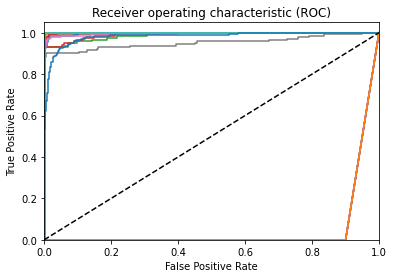

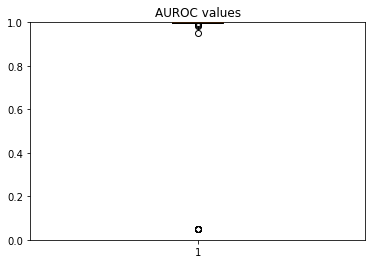

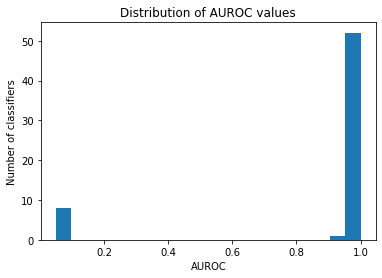

AUROCs:
[1.0, 1.0, 0.9880172610882488, 0.9917752629172382, 0.04991762767710051, 0.9986277390241114, 0.9999454325058562, 1.0, 0.04991762767710051, 1.0, 0.04991762767710051, 0.9999897820163488, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9973932765798794, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9960528739096222, 1.0, 0.9998320864195227, 1.0, 1.0, 0.04991762767710051, 1.0, 0.9994120678893237, 0.04991762767710051, 0.04975288303130149, 0.04991762767710051, 0.9999961873243787, 1.0, 1.0, 1.0, 0.04991762767710051, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.999340804218853, 1.0, 0.9994800037817907, 1.0, 1.0, 0.9999924464262784, 0.9986798679867988, 0.9998352010547132, 0.9516460034952948, 1.0, 0.9988304093567251, 0.9818751981610653]


In [29]:
# Compute ROC curve and ROC area for each class

n_classes = len(y.unique())

fpr = dict()
tpr = dict()
roc_auc = dict()
y_dummies = pd.get_dummies(y, drop_first=False).values
y_score = np.nan_to_num(y_score)

for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_dummies[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

aurocs = [float(i) for i in roc_auc.values()]

print("Number of classes: " + str(n_classes))
print("Median AUROC: " + str(statistics.median(aurocs)))
print("Average AUROC: " + str(statistics.mean(aurocs)))
print("St. dev. AUROC: " + str(statistics.stdev(aurocs)))

# Plot of a ROC curve for a specific class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

plt.figure()
plt.boxplot(aurocs)
plt.ylim([0.0, 1.0])
plt.title('AUROC values')
plt.show()

plt.figure()
plt.hist(aurocs, bins=20)
plt.ylabel('Number of classifiers')
plt.xlabel('AUROC')
plt.title('Distribution of AUROC values')
plt.show()

print("AUROCs:")
print(aurocs)

In [30]:
# spot-check quality of predictions
y_reportable_name = gating_data.loc[y.index.values, reportable_name_column]

output_results = pd.DataFrame(columns=[reportable_name_column, 'Predicted', 'Actual'])

output_results["Actual"] = y_labels
output_results["Predicted"] = y_pred_labels
output_results[reportable_name_column] = y_reportable_name.values

output_results.tail(15)

,Reportable name,Predicted,Actual
3021,PDL1 [CD3+/CD8+/CD62L-/CD127+],CD274,CD274
3022,PDL1+/CD3+/CD4+/CD45RO-/CCR7-,CD274,CD274
3023,PDL1+/CD3+/CD4+/CD45RO-/CCR7+,CD274,CD274
3024,PDL1+/CD3+/CD4+/CD45RO+/CCR7-,CD274,CD274
3025,PDL1+/CD3+/CD4+/CD45RO+/CCR7+,CD274,CD274
3026,PDL1+/CD3+/CD4+/CD45RO+/CD62L-/CCR7-,CD274,CD274
3027,PDL1+/CD3+/CD4+/CD45RO+/CD62L+/CCR7+,CD274,CD274
3028,PDL1+/CD3+/CD4+/CD62L-/CD127+,CD274,CD274
3029,PDL1+/CD3+/CD8+/CD45RO-/CCR7-,CD274,CD274
3030,PDL1+/CD3+/CD8+/CD45RO-/CCR7+,CD274,CD274


In [31]:
# spot-check errors

total_samples = len(output_results.index)

print("Total samples: " + str(total_samples))

total_errors = len(output_results[output_results["Predicted"] != output_results["Actual"]])

print("Total correctly classified: " + str(total_samples - total_errors))

print("Total classification errors: " + str(total_errors))

errors = output_results[output_results["Predicted"] != output_results["Actual"]][["Predicted", "Actual"]]

pd.set_option('display.max_rows', 15)

errors.tail(15)

Total samples: 3036
Total correctly classified: 2885
Total classification errors: 151


,Predicted,Actual
2916,HLA-DR+Ki67+,Ki67+HLA-DR+
2930,CD279,no marker
2931,CD279,no marker
2932,CD279,no marker
2933,CD279,no marker
2934,CD279,no marker
2935,CD279,no marker
2936,CD279,no marker
2937,CD279,no marker
2938,CD279,no marker


# Evaluate predictions based on data source

In [32]:
# select data with source name
gating_data = gating_data[gating_data[source_column].notna()]

total_samples = len(gating_data.index)

print("Number of gating definitions: " + str(total_samples))

# list sources

gating_data[source_column] = gating_data[source_column].str.lower()

sources = gating_data[source_column].unique()

sources = sorted(sources, key=str.lower)

print("Unique sources: " + str(sources))

Number of gating definitions: 3036
Unique sources: ['internal', 'laboratory 1', 'laboratory 2', 'laboratory 3']


In [33]:
# algorithm performance for each source alone and with different levels of train / test split

for test_fraction in [0.9, 0.5]:
    train_fraction = 1 - test_fraction
    print("---------------------------")
    print("Fraction used for training: " + str(train_fraction))
    print("---------------------------")
    for source in sources:
        print("Source: " + source)

        single_source_data = (gating_data[source_column] == source).values 
        X_single_source = feature_matrix[single_source_data]
        y_single_source = y[single_source_data]


        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_single_source, y_single_source, test_size=test_fraction, random_state=24)

        print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
        print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")

        clf = exported_pipeline

        clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test) 

        print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

---------------------------
Fraction used for training: 0.09999999999999998
---------------------------
Source: internal
Training set size: 9 (0.30%)
Test set size: 83 (2.73%)
Accuracy of machine learning algorithm on the test set: 38.6%
Source: laboratory 1
Training set size: 254 (8.37%)
Test set size: 2290 (75.43%)
Accuracy of machine learning algorithm on the test set: 83.1%
Source: laboratory 2
Training set size: 18 (0.59%)
Test set size: 166 (5.47%)
Accuracy of machine learning algorithm on the test set: 70.5%
Source: laboratory 3
Training set size: 21 (0.69%)
Test set size: 195 (6.42%)
Accuracy of machine learning algorithm on the test set: 74.9%
---------------------------
Fraction used for training: 0.5
---------------------------
Source: internal
Training set size: 46 (1.52%)
Test set size: 46 (1.52%)
Accuracy of machine learning algorithm on the test set: 91.3%
Source: laboratory 1
Training set size: 1272 (41.90%)
Test set size: 1272 (41.90%)
Accuracy of machine learning algo

In [34]:
# algorithm performance in one vs. rest (test data comes from different source than training data)

for source in sources:
    print("Source: " + source)
    
    in_source_data = (gating_data[source_column] == source).values 
    out_source_data = (gating_data[source_column] != source).values 
    
    X_test = feature_matrix[in_source_data]
    y_test = y[in_source_data]
    X_train = feature_matrix[out_source_data]
    y_train = y[out_source_data]
    
    print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
    print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")
    
    clf = exported_pipeline

    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test) 

    print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

Source: internal
Training set size: 2944 (96.97%)
Test set size: 92 (3.03%)
Accuracy of machine learning algorithm on the test set: 26.1%
Source: laboratory 1
Training set size: 492 (16.21%)
Test set size: 2544 (83.79%)
Accuracy of machine learning algorithm on the test set: 15.5%
Source: laboratory 2
Training set size: 2852 (93.94%)
Test set size: 184 (6.06%)
Accuracy of machine learning algorithm on the test set: 81.5%
Source: laboratory 3
Training set size: 2820 (92.89%)
Test set size: 216 (7.11%)
Accuracy of machine learning algorithm on the test set: 81.9%


In [35]:
# use a small sample from the same-source dataset in the training set
fraction_passed = 0.1

for fraction_passed in [0.1, 0.5]:
    print("-----------------------")    
    print("Fraction passed: " + str(fraction_passed))
    print("-----------------------")
    for source in sources:
        print("Source: " + source)

        in_source_data1 = gating_data[gating_data[source_column] == source].index
        out_source_data1 = gating_data[gating_data[source_column] != source].index

        in_source_passed_to_out_source = random.sample(set(in_source_data1), int(fraction_passed * len(in_source_data1)))

        in_source_data2 = (gating_data[source_column] == source)
        out_source_data2 = (gating_data[source_column] != source)

        in_source_data2[in_source_passed_to_out_source] = False
        out_source_data2[in_source_passed_to_out_source] = True

        in_source_data3 = in_source_data2.values
        out_source_data3 = out_source_data2.values

        X_test = feature_matrix[in_source_data3]
        y_test = y[in_source_data3]
        X_train = feature_matrix[out_source_data3]
        y_train = y[out_source_data3]

        print("Training set size: " + str(len(X_train.index)) + " (" + "{:.2f}".format(100*len(X_train.index)/len(gating_data.index)) + "%)")
        print("Test set size: " + str(len(X_test.index)) + " (" + "{:.2f}".format(100*len(X_test.index)/len(gating_data.index)) + "%)")

        clf = exported_pipeline

        clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test) 

        print("Accuracy of machine learning algorithm on the test set: " + "{:.1f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

-----------------------
Fraction passed: 0.1
-----------------------
Source: internal
Training set size: 2953 (97.27%)
Test set size: 83 (2.73%)
Accuracy of machine learning algorithm on the test set: 74.7%
Source: laboratory 1
Training set size: 746 (24.57%)
Test set size: 2290 (75.43%)
Accuracy of machine learning algorithm on the test set: 83.0%
Source: laboratory 2
Training set size: 2870 (94.53%)
Test set size: 166 (5.47%)
Accuracy of machine learning algorithm on the test set: 86.7%
Source: laboratory 3
Training set size: 2841 (93.58%)
Test set size: 195 (6.42%)
Accuracy of machine learning algorithm on the test set: 97.4%
-----------------------
Fraction passed: 0.5
-----------------------
Source: internal
Training set size: 2990 (98.48%)
Test set size: 46 (1.52%)
Accuracy of machine learning algorithm on the test set: 97.8%
Source: laboratory 1
Training set size: 1764 (58.10%)
Test set size: 1272 (41.90%)
Accuracy of machine learning algorithm on the test set: 96.8%
Source: lab

# Applying the synonyms of the PRO ontology

In [36]:
feature_matrix = create_features(input_data, list_of_unique_features, synonym_map_new)

X = feature_matrix

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=24)

In [37]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_train) 

print("Accuracy of machine learning algorithm on the training set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_train, y_pred)) + "%")

y_pred = clf.predict(X_test) 

print("Accuracy of machine learning algorithm on the test set: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y_test, y_pred)) + "%")

y_pred = sklearn.model_selection.cross_val_predict(clf, X, y, cv=10)

print("Accuracy of machine learning algorithm on 10-fold cross-validation: " + "{:.2f}".format(100*sklearn.metrics.accuracy_score(y, y_pred)) + "%")


Accuracy of machine learning algorithm on the training set: 99.88%
Accuracy of machine learning algorithm on the test set: 98.52%
Accuracy of machine learning algorithm on 10-fold cross-validation: 95.09%
